In [1]:
# Importing libraries
import pandas as pd
import datetime as dt
import  numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\razas\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Loading data
df = pd.read_csv(r'RFM data.csv')

# Display the first few rows
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [3]:
# Check the data types
df.info()

# Ensuring PurchaseDate is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Check the data types
df.dtypes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392735 entries, 0 to 392734
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    392735 non-null  int64  
 1   StockCode    392735 non-null  object 
 2   Description  392735 non-null  object 
 3   Quantity     392735 non-null  int64  
 4   InvoiceDate  392735 non-null  object 
 5   UnitPrice    392735 non-null  float64
 6   CustomerID   392735 non-null  float64
 7   Country      392735 non-null  object 
 8   TotalPrice   392735 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 27.0+ MB


InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalPrice            float64
dtype: object

In [4]:
# checking for null
print(df.isnull().sum())
# checking for duplicates
print(df.duplicated().sum())
# checking for duplicates in main columns
print(df['CustomerID'].duplicated().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
TotalPrice     0
dtype: int64
5182
388437


In [5]:
# Drop duplicate rows
df.drop_duplicates(keep='first', inplace=True)

In [6]:
# Checking the range of the date for frequency
df['InvoiceDate'].max(),df['InvoiceDate'].min()

(Timestamp('2011-12-09 12:50:00'), Timestamp('2010-12-01 08:26:00'))

In [7]:
# Define the reference date for recency calculation (usually the last date in your dataset)
reference_date = df['InvoiceDate'].max()

# Calculate Recency for each customer
recency_df = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (reference_date - x.max()).days}).reset_index()

# Rename column
recency_df.columns = ['CustomerID', 'Recency']

# Display the Recency table
recency_df.head()

,CustomerID,Recency
0,12347.0,1
1,12348.0,74
2,12349.0,18
3,12350.0,309
4,12352.0,35


In [8]:
# Calculate Frequency for each customer
frequency_df = df.groupby('CustomerID').agg({'InvoiceNo': 'count'}).reset_index()

# Rename column
frequency_df.columns = ['CustomerID', 'Frequency']

# Display the Frequency table
frequency_df.head()

,CustomerID,Frequency
0,12347.0,181
1,12348.0,27
2,12349.0,71
3,12350.0,16
4,12352.0,77


In [9]:
# Calculate Monetary value for each customer
monetary_df = df.groupby('CustomerID').agg({'TotalPrice': 'sum'}).reset_index()

# Rename column
monetary_df.columns = ['CustomerID', 'Monetary']

# Display the Monetary table
monetary_df.head()

,CustomerID,Monetary
0,12347.0,4060.40
1,12348.0,1437.24
2,12349.0,1417.60
3,12350.0,294.40
4,12352.0,1385.74


In [10]:
# Merge Recency, Frequency, and Monetary dataframes
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

# Display the RFM table
rfm_df.head()


rfm_v1 = rfm_df.copy()
rfm_v2 = rfm_df.copy()

In [11]:
rfm_v1["R_rank"] = rfm_v1["Recency"].rank(ascending=False)
rfm_v1["F_rank"] = rfm_v1["Frequency"].rank(ascending=True)
rfm_v1["M_rank"] = rfm_v1["Monetary"].rank(ascending=True)

#normalizing the rank of the customers
rfm_v1["R_rank_norm"] = (rfm_v1["R_rank"]/rfm_v1["R_rank"].max())*100
rfm_v1["F_rank_norm"] = (rfm_v1["F_rank"]/rfm_v1["F_rank"].max())*100
rfm_v1["M_rank_norm"] = (rfm_v1["M_rank"]/rfm_v1["M_rank"].max())*100

rfm_v1.drop(columns=['R_rank','F_rank','M_rank'],inplace=True)

rfm_v1.head()

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,12347.0,1,181,4060.40,97.919116,88.238716,92.647743
1,12348.0,74,27,1437.24,38.443452,37.296417,73.010703
2,12349.0,18,71,1417.60,74.194686,66.449511,72.452303
3,12350.0,309,16,294.40,5.325652,23.394602,25.151233
4,12352.0,35,77,1385.74,58.640959,68.252676,71.870638


In [12]:
# Calculate the weighted RFM score
rfm_v1["RFM_Score"] = 0.34 * rfm_v1['R_rank_norm'] + 0.33 * rfm_v1["F_rank_norm"] + 0.33 * rfm_v1['M_rank_norm']

# Scale the RFM score
rfm_v1["RFM_Score"] *= 0.10

# Round the RFM scores to 2 decimal places
rfm_v1 = rfm_v1.round(2)

# Display the first 7 rows with CustomerID and RFM_Score
rfm_v1.head(7)

,CustomerID,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score
0,12347.0,1,181,4060.40,97.92,88.24,92.65,9.30
1,12348.0,74,27,1437.24,38.44,37.30,73.01,4.95
2,12349.0,18,71,1417.60,74.19,66.45,72.45,7.11
3,12350.0,309,16,294.40,5.33,23.39,25.15,1.78
4,12352.0,35,77,1385.74,58.64,68.25,71.87,6.62
5,12353.0,203,4,89.00,17.04,4.51,3.21,0.83
6,12354.0,231,58,1079.40,14.11,60.61,65.80,4.65


In [13]:
import numpy as np

# Define customer segments based on RFM score
rfm_v1["Customer_segment"] = np.where(
    rfm_v1['RFM_Score'] >= 9,
    'Champions',
    np.where(
        rfm_v1['RFM_Score'] >= 8,
        'Loyal customers',
        np.where(
            rfm_v1['RFM_Score'] >= 7,
            'Potential loyalist',
            np.where(
                rfm_v1['RFM_Score'] >= 6,
                'Recent customers',
                np.where(
                    rfm_v1['RFM_Score'] >= 5,
                    'Promising',
                    np.where(
                        rfm_v1['RFM_Score'] >= 4,
                        'Needs attention',
                        np.where(
                            rfm_v1['RFM_Score'] >= 3,
                            'About to sleep',
                            np.where(
                                rfm_v1['RFM_Score'] >= 2,
                                'At risk',
                                np.where(
                                    rfm_v1['RFM_Score'] >= 1,
                                    "Can't lose them",
                                    'Hibernating' )))))))))

# Display the Invoice ID, RFM Score, and Customer Segment for the top 20 customers
print(rfm_v1[['CustomerID', 'RFM_Score', "Customer_segment"]].head(20))


    CustomerID  RFM_Score    Customer_segment
0      12347.0       9.30           Champions
1      12348.0       4.95     Needs attention
2      12349.0       7.11  Potential loyalist
3      12350.0       1.78     Can't lose them
4      12352.0       6.62    Recent customers
5      12353.0       0.83         Hibernating
6      12354.0       4.65     Needs attention
7      12355.0       2.49             At risk
8      12356.0       7.19  Potential loyalist
9      12357.0       7.93  Potential loyalist
10     12358.0       6.18    Recent customers
11     12359.0       7.76  Potential loyalist
12     12360.0       7.14  Potential loyalist
13     12361.0       1.10     Can't lose them
14     12362.0       9.43           Champions
15     12363.0       3.60      About to sleep
16     12364.0       7.52  Potential loyalist
17     12365.0       2.18             At risk
18     12367.0       3.98      About to sleep
19     12370.0       7.53  Potential loyalist


In [14]:
!pip install squarify


  Obtaining dependency information for squarify from https://files.pythonhosted.org/packages/b7/3c/eedbe9fb07cc20fd9a8423da14b03bc270d0570b3ba9174a4497156a2152/squarify-0.4.4-py3-none-any.whl.metadata


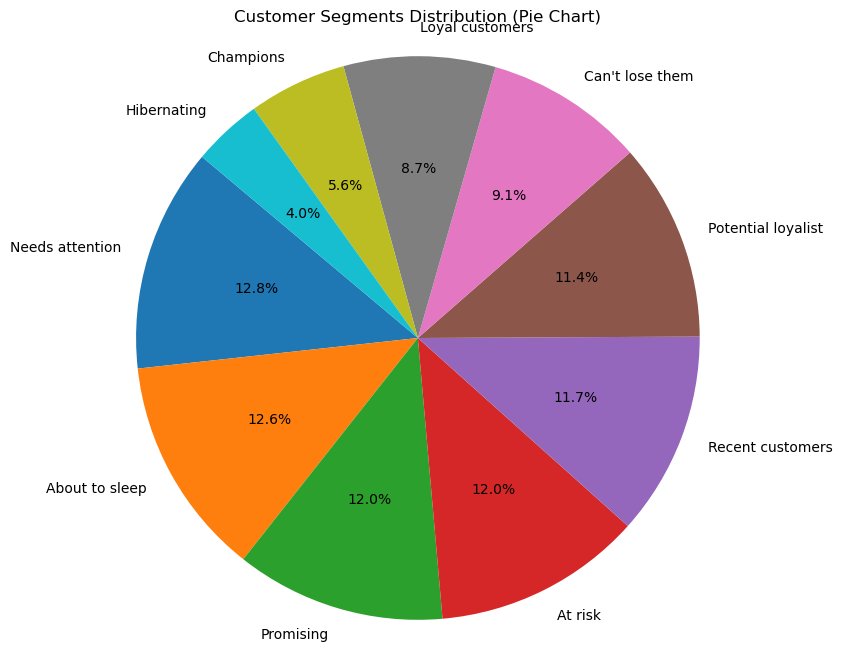

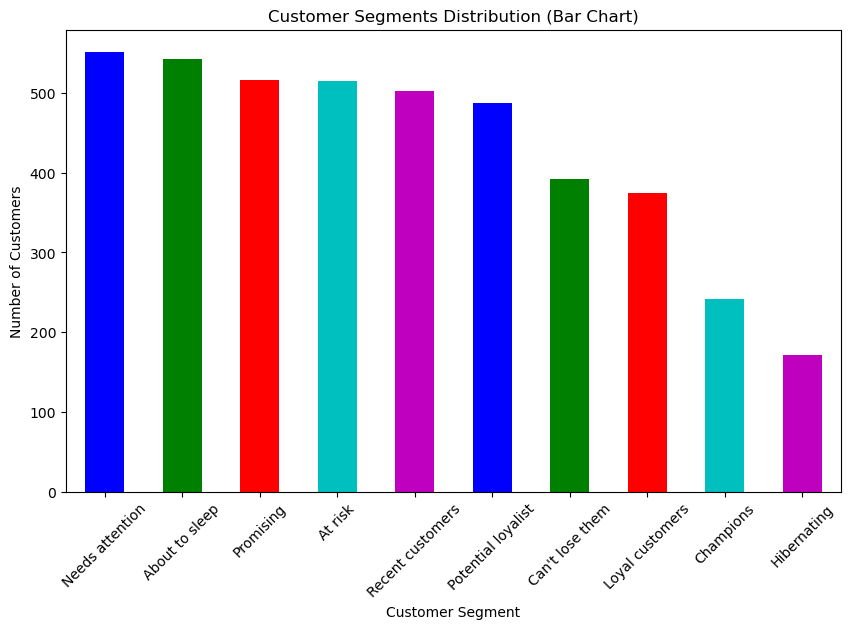

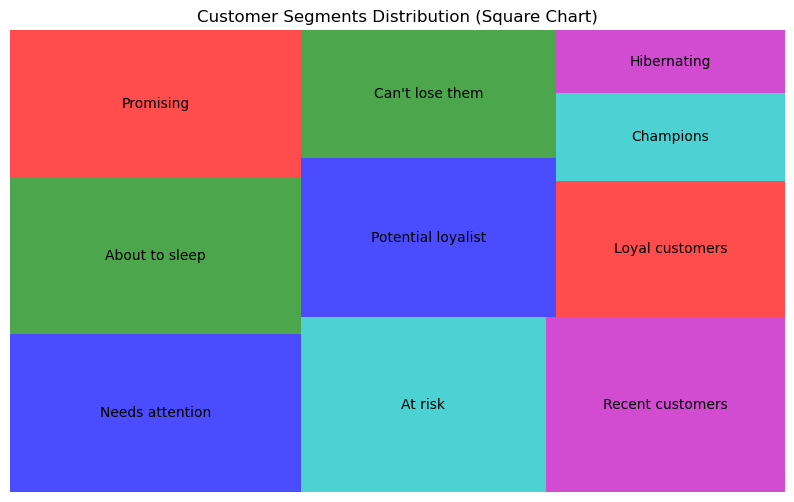

In [15]:
#!pip install squarify
import squarify

# Calculate Segment Counts
segment_counts = rfm_v1['Customer_segment'].value_counts()

# Creating Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

# Creating Bar Chart
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar',color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Bar Chart)')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# creating Square Chart (Treemap)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=segment_counts, label=segment_counts.index, alpha=0.7,color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Square Chart)')
plt.axis('off')
plt.show()


In [16]:
rfm_v2

,CustomerID,Recency,Frequency,Monetary
0,12347.0,1,181,4060.40
1,12348.0,74,27,1437.24
2,12349.0,18,71,1417.60
3,12350.0,309,16,294.40
4,12352.0,35,77,1385.74
...,...,...,...,...
4293,18280.0,277,10,180.60
4294,18281.0,180,7,80.82
4295,18282.0,7,12,178.05
4296,18283.0,3,719,2039.58


In [17]:
rfm_v2['RecencyScore'] = pd.cut(rfm_v2['Recency'], bins=5, labels=[5, 4, 3, 2, 1])
rfm_v2['FrequencyScore'] = pd.cut(rfm_v2['Frequency'], bins=5, labels=[1, 2, 3, 4, 5])
rfm_v2['MonetaryScore'] = pd.cut(rfm_v2['Monetary'], bins=5, labels=[1, 2, 3, 4, 5])

rfm_v2

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore
0,12347.0,1,181,4060.40,5,1,1
1,12348.0,74,27,1437.24,5,1,1
2,12349.0,18,71,1417.60,5,1,1
3,12350.0,309,16,294.40,1,1,1
4,12352.0,35,77,1385.74,5,1,1
...,...,...,...,...,...,...,...
4293,18280.0,277,10,180.60,2,1,1
4294,18281.0,180,7,80.82,3,1,1
4295,18282.0,7,12,178.05,5,1,1
4296,18283.0,3,719,2039.58,5,1,1


In [18]:
# Define customer segments based on RFM score range
rfm_v2["Customer_segment"] = np.where((rfm_v2['RecencyScore']<=4) & (rfm_v2['FrequencyScore']>=4) & (rfm_v2['MonetaryScore']>=4), 'Champions', #1
    np.where((rfm_v2['RecencyScore']<=3) & (rfm_v2['FrequencyScore']>=3) & (rfm_v2['MonetaryScore']>=3), 'Loyal customers/Needs attention',  #2
        np.where((rfm_v2['RecencyScore'] <= 4) & (rfm_v2['FrequencyScore'] >= 2) & (rfm_v2['FrequencyScore'] <= 3) & (rfm_v2['MonetaryScore'] >= 2) & (rfm_v2['MonetaryScore'] <= 3), 'Potential loyalist', #3
            np.where((rfm_v2['RecencyScore']<=4) & (rfm_v2['FrequencyScore']<=1) & (rfm_v2['FrequencyScore']<=1), 'Recent customers/Promising', #4 
                        np.where((rfm_v2['RecencyScore']>=2) & (rfm_v2['FrequencyScore']<=2) & (rfm_v2['MonetaryScore']<=2), 'About to sleep/Hibernating', #7
                            np.where((rfm_v2['RecencyScore']<=2) & (rfm_v2['FrequencyScore']<=3) & (rfm_v2['MonetaryScore']<=3), 'At risk', #8
                                np.where((rfm_v2['RecencyScore']>=2) & (rfm_v2['FrequencyScore']>=5) & (rfm_v2['MonetaryScore']>=5), "Can't lose them", #9
                                        'Other'
)))))))


# Display the CustomerID, RFM Score, and Customer Segment for the top 20 customers
#print(rfm_v2[['CustomerID', 'RecencyScore', 'FrequencyScore', 'MonetaryScore', 'Customer_segment']].head(20))

# Display summary statistics
rfm_v2.describe(include='all')

,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,Customer_segment
count,4298.000000,4298.000000,4298.000000,4298.000000,4298.0,4298.0,4298.0,4298
unique,NaN,NaN,NaN,NaN,5.0,5.0,5.0,6
top,NaN,NaN,NaN,NaN,5.0,1.0,1.0,Recent customers/Promising
freq,NaN,NaN,NaN,NaN,2675.0,4288.0,4284.0,3250
mean,15295.001629,91.626803,90.170544,1661.831056,NaN,NaN,NaN,NaN
std,1720.435019,100.040792,223.639718,5331.802016,NaN,NaN,NaN,NaN
min,12347.000000,0.000000,1.000000,2.900000,NaN,NaN,NaN,NaN
25%,13811.250000,17.000000,17.000000,292.602500,NaN,NaN,NaN,NaN
50%,15289.500000,50.000000,41.000000,641.610000,NaN,NaN,NaN,NaN
75%,16774.750000,142.000000,98.000000,1566.750000,NaN,NaN,NaN,NaN


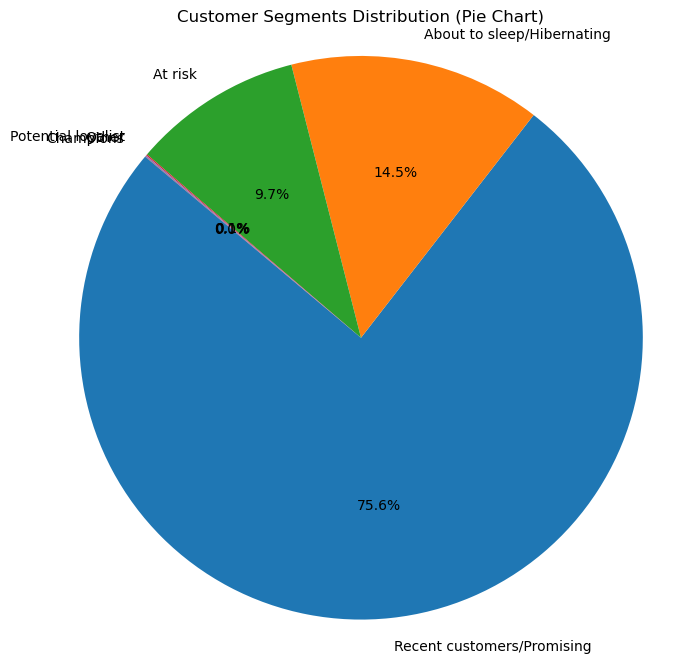

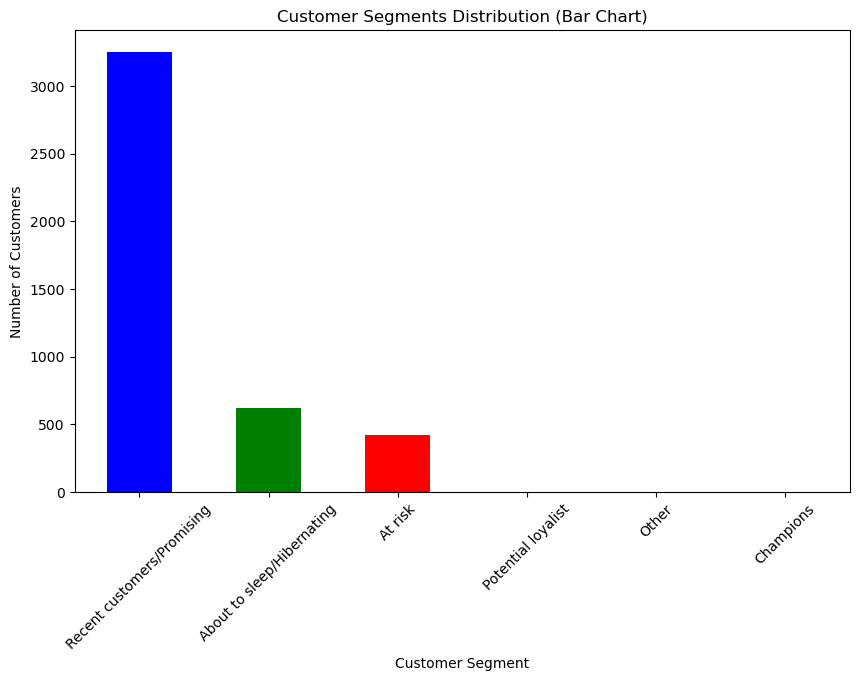

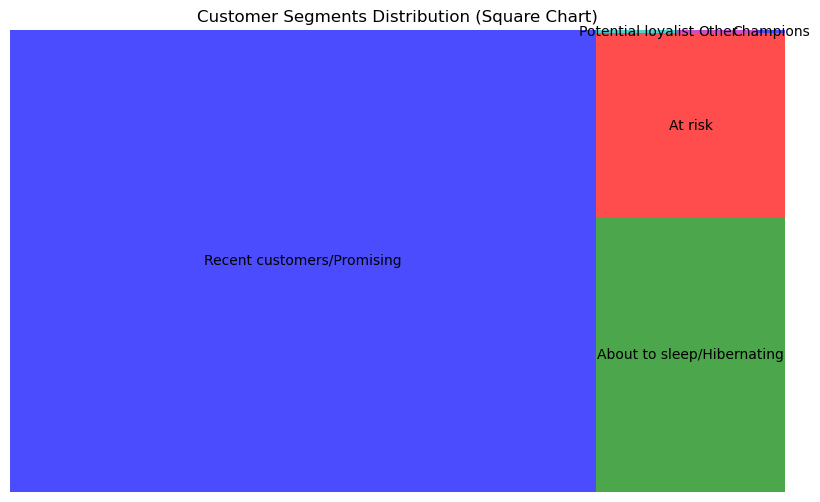

In [19]:
# Calculate Segment Counts
segment_counts = rfm_v2['Customer_segment'].value_counts()

# Creating Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Customer Segments Distribution (Pie Chart)')
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.
plt.show()

# Creating Bar Chart
plt.figure(figsize=(10, 6))
segment_counts.plot(kind='bar',color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Bar Chart)')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

# creating Square Chart (Treemap)
plt.figure(figsize=(10, 6))
squarify.plot(sizes=segment_counts, label=segment_counts.index, alpha=0.7,color=('b','g','r','c','m'))
plt.title('Customer Segments Distribution (Square Chart)')
plt.axis('off')
plt.show()


Loyalty Programs: Reward high-frequency and high-monetary value customers with loyalty programs to encourage repeat purchases and increase customer retention.

Reactivation Campaigns: Implement reactivation campaigns targeting customers with low recency scores to bring them back to the platform through special offers or reminders.

Customer Experience Enhancement: Focus on improving the overall customer experience to retain high-value customers and attract new ones. This includes providing excellent customer service, streamlining the purchase process, and personalizing interactions.